<a href="https://colab.research.google.com/github/jacqueslethuaut/recommendation-system-amazon-products/blob/main/Recommendation_Systems_Amazon_Product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**



 The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------


Amazon is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the several attributes, but we will focus on:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [22]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [23]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data by chunk**

On Google Colab resources are precious, the idea is to save as much resources as possible while loading the dataset from Amazon

In [24]:
import gzip
import requests
import os

def download_file(url, local_filename):
    if os.path.isfile(local_filename):
        # Send a HEAD request to get the size of the file on the server
        response = requests.head(url)
        # Get the size of the file if the HEAD request is successful
        if response.status_code == 200:
            file_size = int(response.headers.get('content-length', 0))
            # Compare the size of the local file with the one on the server
            if os.path.getsize(local_filename) == file_size:
                print(f"{local_filename} already downloaded.")
                return local_filename
            else:
                print(f"{local_filename} exists but is incomplete. Redownloading.")
        else:
            print(f"Could not get file size from server: Status code {response.status_code}")
    # If the file doesn't exist or is incomplete, download it
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename


def process_chunk(chunk):
    # We map the amazon's columns on the features we are tracking
    chunk = chunk[['reviewerID', 'asin', 'overall']]
    chunk.columns = ['user_id', 'prod_id', 'rating']
    return chunk


def getDF(path, chunksize=10000):
    # Create an iterator to read the file in chunks
    chunk_iter = pd.read_json(path, lines=True, compression='gzip', chunksize=chunksize)

    # Initialize an empty list to store processed chunks
    chunks = []

    # Process each chunk
    for chunk in chunk_iter:
        processed_chunk = process_chunk(chunk)
        chunks.append(processed_chunk)

    # Concatenate all processed chunks into a single DataFrame
    df = pd.concat(chunks, ignore_index=True)
    return df

url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics.json.gz'
local_filename = download_file(url, 'reviews_Electronics.json.gz')

df = getDF(local_filename)
df.head()

reviews_Electronics.json.gz already downloaded.


,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5
1,A2CX7LUOHB2NDG,0321732944,5
2,A2NWSAGRHCP8N5,0439886341,1
3,A2WNBOD3WNDNKT,0439886341,3
4,A1GI0U4ZRJA8WN,0439886341,1


In [25]:
df.columns


Index(['user_id', 'prod_id', 'rating'], dtype='object')

In [26]:
df.shape

(7824482, 3)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [27]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [28]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

print(len(remove_users))

df = df.loc[ ~ df.user_id.isin(remove_users)]

4200156


In [29]:
df.shape

(125871, 3)

In [30]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [31]:
# We want our item to have at least 5 ratings to be considered
RATINGS_ITEM_CUTOFF = 5

remove_items = []

for item, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_ITEM_CUTOFF:
        remove_items.append(item)

df_final = df.loc[~ df.prod_id.isin(remove_items)]

In [32]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5
1322,A1A5KUIIIHFF4U,1400501466,1
1335,A2XIOXRRYX0KZY,1400501466,3
1451,AW3LX47IHPFRL,1400501466,5
1456,A1E3OB6QMBKRYZ,1400501466,1


## **Exploratory Data Analysis**

### **Shape of the data**

In [33]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  65290
No of columns:  3


### **Data types**

In [34]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  65290 non-null  object
 1   prod_id  65290 non-null  object
 2   rating   65290 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


### **Checking for missing values**

In [35]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

### **Summary Statistics**

In [36]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


### **Checking the rating distribution**

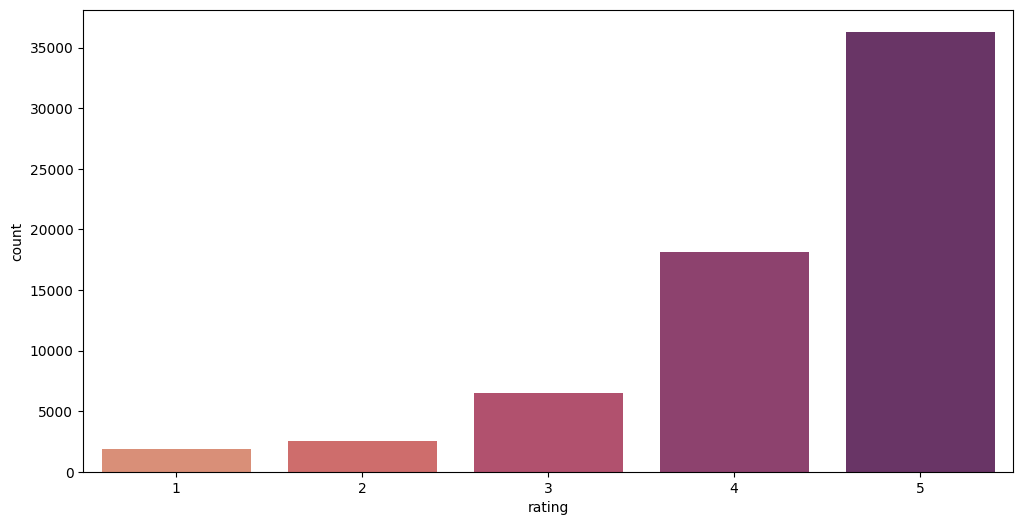

In [79]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 6))
sns.countplot(x= 'rating', data = df_final, palette='flare')
plt.show()

### **Users with the most number of ratings**

In [38]:

ratings_count = df_final.groupby('user_id')['rating'].count()

top_users = ratings_count.sort_values(ascending=False).head(10)
top_users_df = top_users.reset_index()
top_users_df.columns = ['user_id', 'number_of_ratings']

top_users_df.style.background_gradient(cmap='Blues', subset=['number_of_ratings'])


,user_id,number_of_ratings
0,ADLVFFE4VBT8,295
1,A3OXHLG6DIBRW8,230
2,A1ODOGXEYECQQ8,217
3,A36K2N527TXXJN,212
4,A25C2M3QF9G7OQ,203
5,A680RUE1FDO8B,196
6,A22CW0ZHY3NJH8,193
7,A1UQBFCERIP7VJ,193
8,AWPODHOB4GFWL,184
9,A3LGT6UZL99IW1,179


The 10 highest numbers of ratings by a user is in the range [179-295] which is far from the actual number of products present in the data.

Let's build a recommendation system to recommend products to users which they have not interacted with.

## **Model 1: Rank Based Recommendation System**

In [39]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5
1322,A1A5KUIIIHFF4U,1400501466,1
1335,A2XIOXRRYX0KZY,1400501466,3
1451,AW3LX47IHPFRL,1400501466,5
1456,A1E3OB6QMBKRYZ,1400501466,1


In [40]:
average_rating = df_final.groupby('prod_id').mean()['rating']

count_rating = df_final.groupby('prod_id').count()['rating']
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})
final_rating = final_rating.sort_values(by = 'avg_rating', ascending = False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [41]:
def top_n_products(final_rating, n, min_interaction):
    '''
    Defining a function to get the top n products based on
    the highest average rating and minimum interactions
    '''
    recommendations = final_rating[final_rating['rating_count'] > min_interaction]
    recommendations = recommendations.sort_values(by = 'avg_rating',
                                                  ascending = False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [42]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [43]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example -
<ol>
    <li><b>Ratings</b> provided by users. For example, ratings of books on goodread, movie ratings on imdb, etc.</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos.</li>
    <li><b>Use/buying</b> of a product by users. For example, buying different items on e-commerce sites.</li>
    <li><b>Reading</b> of articles by readers on various blogs.</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [44]:
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [45]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """
    Return precision and recall at k metrics for each user
    """
    user_est_true = defaultdict(list)
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key = lambda x: x[0], reverse = True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    accuracy.rmse(predictions)

    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3))


**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [46]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5
1322,A1A5KUIIIHFF4U,1400501466,1
1335,A2XIOXRRYX0KZY,1400501466,3
1451,AW3LX47IHPFRL,1400501466,5
1456,A1E3OB6QMBKRYZ,1400501466,1


In [47]:
reader = Reader(rating_scale = (0, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**



In [48]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)
sim_user_user.fit(trainset)

precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5 which is denoted by the parameter r_ui.

In [49]:
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [50]:
df_final[df_final.prod_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [51]:
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

### **Improving Similarity-based Recommendation System by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [52]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {'name': ['msd', 'cosine','pearson','pearson_baseline'],
                    'user_based': [True], 'min_support':[2,4]}
    }

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9809892919754196
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [53]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = gs.best_params['rmse']['sim_options']

sim_user_user_optimized = KNNBasic(sim_options = sim_options,
                                   k = gs.best_params['rmse']['k'],
                                   min_k = gs.best_params['rmse']['min_k'],
                                   random_state = 1,
                                   verbose = False
                                   )
sim_user_user_optimized.fit(trainset)
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9616
Precision:  0.848
Recall:  0.891
F_1 score:  0.869


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [54]:
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [55]:
sim_user_user_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

### **Identifying similar Users to a given User (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [56]:
# 0 is the inner id of the user
sim_user_user_optimized.get_neighbors(0, 5)

[54, 71, 94, 105, 113]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [57]:
def get_recommendations(data, user_id, top_n, algo):
    recommendations = []
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    for item_id in non_interacted_products:
        est = algo.predict(user_id, item_id).est
        recommendations.append((item_id, est))

    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n]


**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [58]:
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [59]:
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00017LSPI,5.000000
1,B001E1Y5O6,5.000000
2,B002V8C3W2,5.000000
3,B002WE4HE2,5.000000
4,B000LRMS66,4.739485


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [60]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)
sim_item_item.fit(trainset)

precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`**. Here the user has already interacted or watched the product with productId "1400501466".

In [61]:
sim_item_item.predict('A3LDPF5FMB782Z', '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [62]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

### **Hyperparameter tuning the item-item similarity-based model**

- Use the following values for the param_grid and tune the model
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [63]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {'name': ['msd', 'cosine'],
                    'user_based': [False], "min_support":[2,4]}
    }

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9852312902366718
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False, 'min_support': 2}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [64]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = gs.best_params['rmse']['sim_options']

sim_item_item_optimized = KNNBasic(sim_options = sim_options,
                                   k = gs.best_params['rmse']['k'],
                                   min_k = gs.best_params['rmse']['min_k'],
                                   random_state = 1,
                                   verbose = False)

sim_item_item_optimized.fit(trainset)

precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9693
Precision:  0.835
Recall:  0.89
F_1 score:  0.862


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [65]:
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [66]:
sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [67]:
sim_item_item_optimized.get_neighbors(0, k=5)

[315, 366, 1282, 3132, 534]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

In [68]:
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [69]:
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 3: Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [70]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

svd.fit(trainset)
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Not the best one compared to Model 1 and 2**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [71]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [72]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [73]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
    }

gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
gs_.fit(data)

print(gs_.best_score['rmse'])
print(gs_.best_params['rmse'])

0.8999356674194492
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [76]:
svd_optimized = SVD(n_epochs=gs_.best_params['rmse']['n_epochs'],
                    lr_all=gs_.best_params['rmse']['lr_all'],
                    reg_all=gs_.best_params['rmse']['reg_all'],
                    random_state=1)

svd_optimized.fit(trainset)
precision_recall_at_k(svd_optimized)

RMSE: 0.8822
Precision:  0.854
Recall:  0.884
F_1 score:  0.869


**Let's now predict a rating for a user with `userId = "A3LDPF5FMB782Z"` and `productId = "1400501466"` with the optimized model.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [77]:
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0394144191097014, details={'was_impossible': False})

In [78]:
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.17   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.172649353607237, details={'was_impossible': False})